# Importing Neccessary Libraries

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import emoji
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Setting Data Paths

In [41]:
data_path_train = 'Train\eRisk2023-T3_Subject'
no_of_training_instances = 46
data_path_test = 'Test\eRisk2022-T3_Subject'
no_of_testing_instances = 28
number_of_questions = 22

# Data Cleaning Functions

1. **Making the name of the Columns Same**

In [3]:
def make_coloumns_same(data_path, no_of_instances):

    for i in range(1, no_of_instances+1):
        df = pd.read_csv(f'{data_path}{i}.csv')
        
        # If a column is called "WRITING.TEXT", rename it to "WRITING.TEXT.Element:Text"
        if "WRITING.TEXT" in df.columns:
            df.rename(columns={"WRITING.TEXT": "WRITING.TEXT.Element:Text"}, inplace=True)
            df.to_csv(f'{data_path}{i}.csv', index=False)
        else:
            continue

2. **Following Data Cleaning operations are performed:**


    1. Remove the trailing b" and the ending "
    2. Replacing unicode characters with their actual characters
    3. Replacing emojis with their text descriptions

In [4]:
def data_cleaning(data_path, no_of_instances):

    for i in range(1, no_of_instances + 1):

        df = pd.read_csv(f'{data_path}{i}.csv')

        for index, row in df.iterrows():

            text_value = row['WRITING.TEXT.Element:Text']

            if isinstance(text_value, str):

                if ((text_value[2] == "'" or text_value[2] == '"') and (text_value[-2] == "'" or text_value[-2] == '"') and (text_value[0] == ' ' and text_value[1] == 'b' and text_value[-1] == ' ')):
                    df.at[index, 'WRITING.TEXT.Element:Text'] = text_value[3:-2]
                    text_value = text_value[3:-2]

                # Replace specific substrings
                text_value = text_value.replace('\\xe2\\x80\\x99', "'")
                text_value = text_value.replace('\\xe2\\x80\\x94', "-")
                text_value = text_value.replace('\\n', " ")

                # Define the regular expression pattern to match words starting with \xf0\x9f
                pattern = r'\\xf0\\x9f\S*'
                # Replace matched words with a single space
                text_value = re.sub(pattern, ' ', text_value)

                # Replace emoji with their text description
                text_value = emoji.demojize(text_value)
                df.at[index, 'WRITING.TEXT.Element:Text'] = text_value
                
            elif isinstance(text_value, float) and np.isnan(text_value):
                # Handle NaN values if needed
                pass
        
        df.to_csv(f'{data_path}{i}.csv', index=False)

3. **Making the final DataFrame before applying models to it**


In [6]:
def make_dataframe(data_path, no_of_instances, type):
    
    data_list = []
    df_final = pd.DataFrame(columns=['Subject', 'text'])

    if type == 'train':
        subject_name = 'eRisk2023-T3_Subject'
    
    else:
        subject_name = 'eRisk2022-T3_Subject'

    for i in range(1, no_of_instances+1):
        # Read the CSV file
        df = pd.read_csv(f'{data_path}{i}.csv')
        
        # Append the data to df
        data_to_append = ""

        for index, row in df.iterrows():
            if isinstance(row['WRITING.TEXT.Element:Text'], str):
                data_to_append = data_to_append + row['WRITING.TEXT.Element:Text'] + " "

        final_data = {'Subject': f'{subject_name}{i}', 'text': data_to_append}
        data_list.append(final_data)

    df_final = pd.DataFrame(data_list)
    return df_final

# Data Preprocessing Functions

1. Lowercasing
2. Removing URLs
3. Removing Punctuations
4. Removing Stopwords
5. Lemmatization

In [7]:
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

In [8]:
def data_preprocessing(df):

    for index, row in df.iterrows():
        text_value = row['text']

        # lowercasing
        text_value = text_value.lower()

        # Remove URLs
        text_value = remove_urls(text_value)

        # Remove punctuation
        text_value = re.sub(r'[^\w\s]', '', text_value)

        # remove stopwords
        stop_words = set(stopwords.words('english'))
        text_value = ' '.join([word for word in text_value.split() if word not in stop_words])

        # lemmatization
        lemmatizer = WordNetLemmatizer()
        text_value = ' '.join([lemmatizer.lemmatize(word) for word in text_value.split()])
        
        # store the cleaned text
        df.at[index, 'text'] = text_value

    return df

# Storing all the labels in one Pandas DataFrame

In [9]:
def extract_labels(type):

    if type == 'train':

        label_list = []
        
        with open('golden-truth_eRisk2023_T3.txt', 'r') as file:
            for line in file:
                # go till the first space or tab is found
                index = 0
                while line[index] != ' ' and line[index] != '\t':
                    index += 1

                temp_list = []
                total_questions = 0

                # there are 22 questions, and each have an integer value separated by a space. store all these values sequentially in temp_list
                for i in range(22):
                    index += 1
                    while (line[index] == ' ' or line[index] == '\t'):
                        index += 1
                    temp_list.append(int(line[index]))
                    total_questions += 1

                label_list.append(temp_list)

    else:

        label_list = []
        
        with open('ground-truth_eRisk2022_T3.txt', 'r') as file:
            for line in file:
                # go till the first space or tab is found
                index = 0
                while line[index] != ' ' and line[index] != '\t':
                    index += 1

                temp_list = []
                total_questions = 0

                # there are 22 questions, and each have an integer value separated by a space. store all these values sequentially in temp_list
                for i in range(22):
                    index += 1
                    while (line[index] == ' ' or line[index] == '\t'):
                        index += 1
                    temp_list.append(int(line[index]))
                    total_questions += 1

                label_list.append(temp_list)

    return label_list

In [15]:
labels_train = extract_labels('train')
labels_test = extract_labels('test')

# Defining the Accuracy Metrics

In [63]:
def mean_zero_one_error(y_true, y_pred):

    individual_errors = []

    for i in range(len(y_true)):
        no_of_misclassifications = 0
        
        for j in range(len(y_true[i])):
            if y_true[i][j] != y_pred[i][j]:
                no_of_misclassifications += 1

        individual_errors.append(no_of_misclassifications/22.0)

    return np.mean(individual_errors)

In [65]:
def mean_absolute_error(y_true, y_pred):

    individual_errors = []

    for i in range(len(y_true)):
        total_error = 0
        
        for j in range(len(y_true[i])):
            total_error += abs(y_true[i][j] - y_pred[i][j])
            
        individual_errors.append(total_error/22.0)

    return np.mean(individual_errors)

In [67]:
def macroaveraged_mean_absolute_error(y_true, y_pred):

    individual_errors = []

    for i in range(len(y_true)):
        total_error = [0, 0, 0, 0, 0, 0, 0]
        total_points = [0, 0, 0, 0, 0, 0, 0]
        
        for j in range(len(y_true[i])):
            total_error[y_true[i][j]] += abs(y_true[i][j] - y_pred[i][j])
            total_points[y_true[i][j]] += 1

        final_error = 0

        for k in range(7):
            if total_points[k] != 0:
                final_error += total_error[k]/(total_points[k]*1.0)
        
        individual_errors.append(final_error/7.0)

    return np.mean(individual_errors)

In [69]:
def restrained_subscale(y_true, y_pred):
    
    indices = [0,1,2,3,4]
    total_error = 0

    for i in range(len(y_true)):

        system_score = 0
        real_score = 0

        for j in indices:
            system_score += y_pred[i][j]
            real_score += y_true[i][j]
        
        system_score = system_score/(len(indices)*1.0)
        real_score = real_score/(len(indices)*1.0)

        total_error += (system_score - real_score)**2

    total_error = total_error/(len(y_true)*1.0)
    total_error = np.sqrt(total_error)

    return total_error
    

In [70]:
def eating_concern_subscale(y_true, y_pred):
    
    indices = [6,8,12,13,14]
    total_error = 0

    for i in range(len(y_true)):

        system_score = 0
        real_score = 0

        for j in indices:
            system_score += y_pred[i][j]
            real_score += y_true[i][j]
        
        system_score = system_score/(len(indices)*1.0)
        real_score = real_score/(len(indices)*1.0)

        total_error += (system_score - real_score)**2

    total_error = total_error/(len(y_true)*1.0)
    total_error = np.sqrt(total_error)

    return total_error

In [72]:
def shape_concern_subscale(y_true, y_pred):
    
    indices = [5,7,9,10,16,19,20,21]
    total_error = 0

    for i in range(len(y_true)):

        system_score = 0
        real_score = 0

        for j in indices:
            system_score += y_pred[i][j]
            real_score += y_true[i][j]
        
        system_score = system_score/(len(indices)*1.0)
        real_score = real_score/(len(indices)*1.0)

        total_error += (system_score - real_score)**2

    total_error = total_error/(len(y_true)*1.0)
    total_error = np.sqrt(total_error)

    return total_error

In [73]:
def weight_concern_subscale(y_true, y_pred):

    indices = [7,11,15,17,18]
    total_error = 0

    for i in range(len(y_true)):

        system_score = 0
        real_score = 0

        for j in indices:
            system_score += y_pred[i][j]
            real_score += y_true[i][j]
        
        system_score = system_score/(len(indices)*1.0)
        real_score = real_score/(len(indices)*1.0)

        total_error += (system_score - real_score)**2

    total_error = total_error/(len(y_true)*1.0)
    total_error = np.sqrt(total_error)

    return total_error

In [74]:
def global_ED(y_true, y_pred):

    indices_r = [0,1,2,3,4]
    indices_e = [6,8,12,13,14]
    indices_s = [5,7,9,10,16,19,20,21]
    indices_w = [7,11,15,17,18]

    size_lists = [5,5,8,5]

    total_error = 0

    for i in range(len(y_true)):

        system_score = [0, 0, 0, 0]
        real_score = [0, 0, 0, 0]
        total_error_system = 0
        total_error_real = 0

        for j in indices_r:
            system_score[0] += y_pred[i][j]
            real_score[0] += y_true[i][j]
        
        for j in indices_e:
            system_score[1] += y_pred[i][j]
            real_score[1] += y_true[i][j]
        
        for j in indices_s:
            system_score[2] += y_pred[i][j]
            real_score[2] += y_true[i][j]
        
        for j in indices_w:
            system_score[3] += y_pred[i][j]
            real_score[3] += y_true[i][j]

        for k in range(4):
            system_score[k] = system_score[k]/(size_lists[k]*1.0)
            real_score[k] = real_score[k]/(size_lists[k]*1.0)

            total_error_system += system_score[k]
            total_error_real += real_score[k]
        
        total_error_system = total_error_system/(4.0)
        total_error_real = total_error_real/(4.0)

        total_error += (total_error_system - total_error_real)**2

    total_error = total_error/(len(y_true)*1.0)
    total_error = np.sqrt(total_error)

    return total_error

In [75]:
def find_all_metrics(y_true, y_pred):

    print("Mean Zero-One Error: ", mean_zero_one_error(y_true, y_pred))
    print("Mean Absolute Error: ", mean_absolute_error(y_true, y_pred))
    print("Macroaveraged Mean Absolute Error: ", macroaveraged_mean_absolute_error(y_true, y_pred))
    print("Restrained Subscale: ", restrained_subscale(y_true, y_pred))
    print("Eating Concern Subscale: ", eating_concern_subscale(y_true, y_pred))
    print("Shape Concern Subscale: ", shape_concern_subscale(y_true, y_pred))
    print("Weight Concern Subscale: ", weight_concern_subscale(y_true, y_pred))
    print("Global ED: ", global_ED(y_true, y_pred))

# Machine Learning Models

**Multinomial Naive Bayes**

In [48]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer


def multinomial_naves_bayes(question_number, labels_train, labels_test, df_train, df_test):

    nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
    
    # Train the model
    X_train = df_train['text']
    y_train = []

    for i in range(len(labels_train)):
        y_train.append(labels_train[i][question_number])

    nb.fit(X_train, y_train)

    # Test the model
    X_test = df_test['text']
    y_pred = nb.predict(X_test)

    return y_pred

**Linear Support Vector Machine**

In [77]:
from sklearn.linear_model import SGDClassifier

def linear_SVM(question_number, labels_train, labels_test, df_train, df_test):

    sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])

    # Train the model
    X_train = df_train['text']
    y_train = []

    for i in range(len(labels_train)):
        y_train.append(labels_train[i][question_number])
    
    sgd.fit(X_train, y_train)

    # Test the model
    X_test = df_test['text']
    y_pred = sgd.predict(X_test)

    return y_pred

**Logistic Regression**

In [83]:
from sklearn.linear_model import LogisticRegression

def logistic_regression(question_number, labels_train, labels_test, df_train, df_test):

    logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5)),
               ])

    # Train the model
    X_train = df_train['text']
    y_train = []

    for i in range(len(labels_train)):
        y_train.append(labels_train[i][question_number])
    
    logreg.fit(X_train, y_train)

    # Test the model
    X_test = df_test['text']
    y_pred = logreg.predict(X_test)

    return y_pred

**Neural Network**

In [108]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer

In [135]:
class CustomDataset(Dataset):
    def __init__(self, X, y, max_words):
        self.X = X
        self.y = y
        self.max_words = max_words
        self.vectorizer = CountVectorizer(max_features=max_words)
        self.vectorizer.fit(X)  # Fit the vectorizer with training data

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        text = self.X[idx]
        label = self.y[idx]
        text_vectorized = self.vectorizer.transform([text]).toarray().squeeze()
        return text_vectorized, label

class NeuralNetwork(nn.Module):
    def __init__(self, input_size, num_classes):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

def neural_network(question_number, labels_train, labels_test, df_train, df_test):
    X_train = df_train['text']
    y_train = [labels_train[i][question_number] for i in range(len(labels_train))]
    X_test = df_test['text']
    y_test = [labels_test[i][question_number] for i in range(len(labels_test))]

    max_words = 1000
    dataset_train = CustomDataset(X_train, y_train, max_words)
    dataset_test = CustomDataset(X_test, y_test, max_words)

    train_loader = DataLoader(dataset_train, batch_size=32, shuffle=True)
    test_loader = DataLoader(dataset_test, batch_size=32, shuffle=False)

    input_size = max_words
    num_classes = 7

    model = NeuralNetwork(input_size, num_classes)
    optimizer = optim.Adam(model.parameters())
    criterion = nn.CrossEntropyLoss()

    epochs = 5
    model.train()
    for epoch in range(epochs):
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs.float())
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    model.eval()
    predictions = []
    with torch.no_grad():
        for inputs, _ in test_loader:
            outputs = model(inputs.float())
            _, predicted = torch.max(outputs, 1)
            predictions.extend(predicted.tolist())

    return predictions

sample_nn = NeuralNetwork(1000, 7)
print(sample_nn)

NeuralNetwork(
  (fc1): Linear(in_features=1000, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=7, bias=True)
)


# Preprocessing Training Data

In [35]:
make_coloumns_same(data_path_train, no_of_training_instances)
data_cleaning(data_path_train, no_of_training_instances)
df_train = make_dataframe(data_path_train, no_of_training_instances, 'train')
df_train = data_preprocessing(df_train)

df_train.head()

,Subject,text
0,eRisk2023-T3_Subject1,idk mate since 1796 using vaccine still waitin...
1,eRisk2023-T3_Subject2,loved ideaconcept feel like film left many thi...
2,eRisk2023-T3_Subject3,dont need certification start working h motor ...
3,eRisk2023-T3_Subject4,leangains method rept fitness workout tracker ...
4,eRisk2023-T3_Subject5,think opinion system led anxiety havent change...


In [36]:
df_train

,Subject,text
0,eRisk2023-T3_Subject1,idk mate since 1796 using vaccine still waitin...
1,eRisk2023-T3_Subject2,loved ideaconcept feel like film left many thi...
2,eRisk2023-T3_Subject3,dont need certification start working h motor ...
3,eRisk2023-T3_Subject4,leangains method rept fitness workout tracker ...
4,eRisk2023-T3_Subject5,think opinion system led anxiety havent change...
5,eRisk2023-T3_Subject6,volunteer waited late 30 family took much ther...
6,eRisk2023-T3_Subject7,find self thinking food lot wanting eat etc ac...
7,eRisk2023-T3_Subject8,wale country catalonia 3xe2x98xbaxefxb8x8f def...
8,eRisk2023-T3_Subject9,function word everything task content word muc...
9,eRisk2023-T3_Subject10,em polypharmacy much 80yo gramma taking idea s...


In [37]:
df_train.to_csv('train.csv', index=False)

# Data Visualisation

**Text Length V Instances Plot**

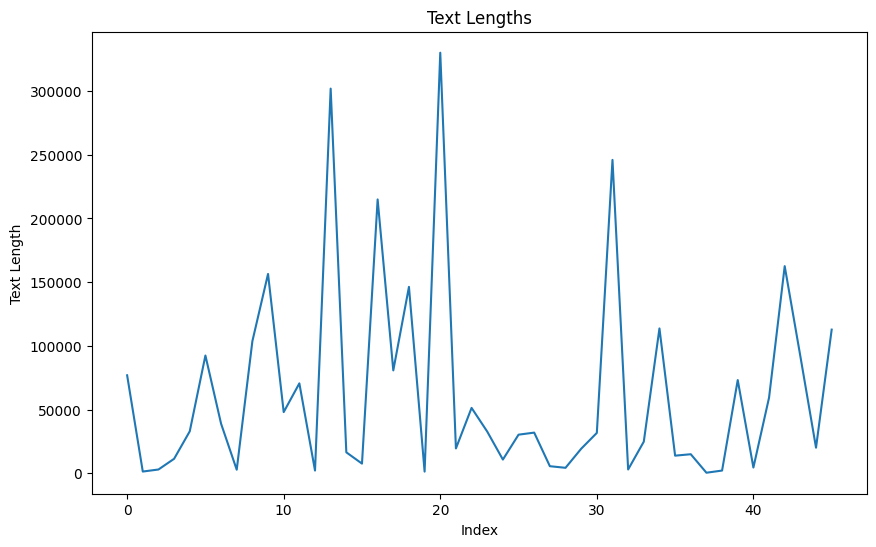

In [120]:
text_lengths = df_train['text'].apply(len)
plt.figure(figsize=(10, 6))
# plot a bar chartgraph
plt.plot(text_lengths)
plt.title('Text Lengths')
plt.xlabel('Index')
plt.ylabel('Text Length')
plt.show()

**Distribution of Text Length**

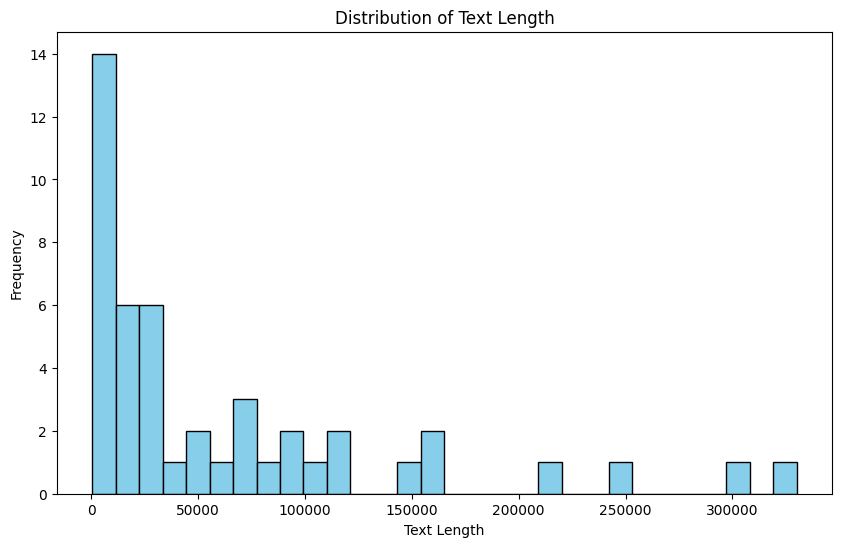

In [121]:
text_lengths = df_train['text'].apply(len)

# Plotting the distribution
plt.figure(figsize=(10, 6))
plt.hist(text_lengths, bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Text Length')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

**Most Common N-Grams**

In [122]:
from sklearn.feature_extraction.text import CountVectorizer

# Create a CountVectorizer object
count_vectorizer = CountVectorizer(ngram_range=(2, 2))

# Fit and transform the text data
ngram_data = count_vectorizer.fit_transform(df_train['text'])

# Store the n-gram data in a DataFrame
ngram_df = pd.DataFrame(ngram_data.toarray(), columns=count_vectorizer.get_feature_names_out())

# Sum the occurrences of each n-gram
ngram_counts = ngram_df.sum()

# Sort the n-grams by frequency
ngram_counts = ngram_counts.sort_values(ascending=False)

# Display the 10 most common n-grams
ngram_counts.head(10)

feel like          543
dont know          445
eating disorder    403
dont want          288
dont think         282
look like          225
sound like         216
im sure            202
even though        180
make sense         153
dtype: int64

**Relevant Words Analysis using Word2Vec**

In [126]:
from gensim.models import Word2Vec
import nltk
nltk.download('punkt')  # Make sure to have the punkt tokenizer downloaded

# Tokenize the sentences
tokenized_corpus = [nltk.word_tokenize(sentence.lower()) for sentence in df_train['text']]

# Train Word2Vec model
model = Word2Vec(sentences=tokenized_corpus, vector_size=100, window=5, min_count=1, workers=4)

# Retrieve the word embedding for "food"
food_embedding = model.wv['food']

print("Word Embedding for 'food':", food_embedding)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\91900\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


Word Embedding for 'food': [ 0.09896016  1.1175162   0.4014102   0.28502992 -0.07558895 -1.1316208
  0.3898303   1.9542687  -0.5694077  -0.42560315 -0.452752   -0.72157925
 -0.01915473  0.25941432  0.21395949 -0.7601462  -0.06205929 -0.9126611
  0.12396684 -1.5320469   0.6513112   0.13290778  0.19190112 -0.21886745
 -0.02676413 -0.30988935 -0.7881518  -0.5179168  -0.10626888  0.16344328
  1.0163852   0.58993095  0.3367984  -0.96814126 -0.28230283  0.8406765
 -0.06022361 -0.3941189  -0.54583406 -1.7474471   0.24584076 -0.9068461
 -0.40213487  0.23023677  0.7440899  -0.5860494  -0.62801987  0.00581882
  0.6883662   0.8939086   0.34958145 -0.6732001  -0.3933038  -0.6010126
 -0.61504453  0.7607724  -0.09765301  0.04697566 -1.1197114  -0.01455687
  0.14677206  0.56860375 -0.45509684 -0.0642701  -1.1386216   0.6442071
  0.45447597  0.6963921  -1.0590612   1.0109828  -0.61620593  0.27449298
  1.1017183  -0.06006506  0.6166811  -0.15906653  0.26821914 -0.00632291
 -0.3573404   0.63549906 -0.63

In [127]:
print("Shape of the word embedding:", food_embedding.shape)

Shape of the word embedding: (100,)


In [131]:
# Most similar words to "food" based on euclidean distance, top 100 words
similar_words = model.wv.most_similar('food', topn=100)
print(similar_words)

[('binge', 0.9995546340942383), ('meal', 0.9993753433227539), ('ed', 0.999364972114563), ('finish', 0.9993568658828735), ('fast', 0.9993310570716858), ('control', 0.9993168115615845), ('reason', 0.9992819428443909), ('straight', 0.9992722272872925), ('brain', 0.9992676973342896), ('voice', 0.9992669820785522), ('often', 0.9992617964744568), ('etc', 0.999255895614624), ('fat', 0.9992532730102539), ('felt', 0.999250054359436), ('healthy', 0.9992491006851196), ('le', 0.9992429614067078), ('water', 0.9992420673370361), ('calorie', 0.9992362856864929), ('little', 0.9992293119430542), ('pay', 0.9992249608039856), ('head', 0.9992240071296692), ('force', 0.9992235898971558), ('purging', 0.9992212653160095), ('longer', 0.9992210865020752), ('easy', 0.999218225479126), ('full', 0.9992106556892395), ('song', 0.9992095828056335), ('normal', 0.99920654296875), ('order', 0.9992055296897888), ('decision', 0.9992021918296814), ('moment', 0.9992009997367859), ('literally', 0.9991992712020874), ('energy

In [132]:
user_similar_words = []

for index, row in df_train.iterrows():
    text = row['text']
    user_similar_words.append({'Subject': row['Subject'], 'similar_words': {word: text.count(word) for word, _ in similar_words}})

# Convert the list of dictionaries to a DataFrame
user_similar_words_df = pd.DataFrame(user_similar_words)


# rank the users on the basis of the number of times the similar wordcount summation appear in their text
user_similar_words_df['score'] = user_similar_words_df['similar_words'].apply(lambda x: sum(x.values()))

# Sort the DataFrame based on the rank
user_similar_words_df = user_similar_words_df.sort_values(by='score', ascending=False)

# Display the DataFrame
user_similar_words_df

,Subject,similar_words,score
13,eRisk2023-T3_Subject14,"{'binge': 135, 'meal': 77, 'ed': 2563, 'finish...",10107
20,eRisk2023-T3_Subject21,"{'binge': 4, 'meal': 17, 'ed': 2613, 'finish':...",9436
31,eRisk2023-T3_Subject32,"{'binge': 0, 'meal': 12, 'ed': 1876, 'finish':...",7011
16,eRisk2023-T3_Subject17,"{'binge': 0, 'meal': 4, 'ed': 1653, 'finish': ...",6315
42,eRisk2023-T3_Subject43,"{'binge': 9, 'meal': 18, 'ed': 1398, 'finish':...",4895
9,eRisk2023-T3_Subject10,"{'binge': 0, 'meal': 9, 'ed': 1311, 'finish': ...",4812
18,eRisk2023-T3_Subject19,"{'binge': 0, 'meal': 3, 'ed': 1164, 'finish': ...",4520
45,eRisk2023-T3_Subject46,"{'binge': 2, 'meal': 0, 'ed': 1133, 'finish': ...",3738
34,eRisk2023-T3_Subject35,"{'binge': 0, 'meal': 5, 'ed': 730, 'finish': 1...",2705
8,eRisk2023-T3_Subject9,"{'binge': 0, 'meal': 1, 'ed': 639, 'finish': 0...",2607


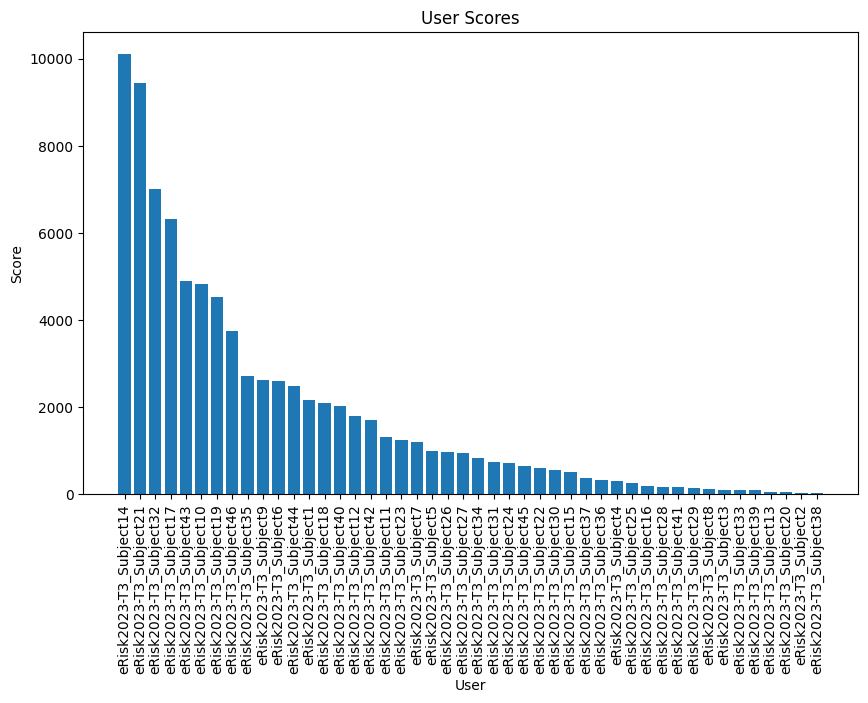

In [133]:
# plot the score of each user in the training set as a bar chart
plt.figure(figsize=(10, 6))
plt.bar(user_similar_words_df['Subject'], user_similar_words_df['score'])
plt.title('User Scores')
plt.xlabel('User')
plt.ylabel('Score')
plt.xticks(rotation=90)
plt.show()

# Preprocessing Testing Data

In [38]:
make_coloumns_same(data_path_test, no_of_testing_instances)
data_cleaning(data_path_test, no_of_testing_instances)
df_test = make_dataframe(data_path_test, no_of_testing_instances, 'test')
df_test = data_preprocessing(df_test)

df_test.head()

,Subject,text
0,eRisk2022-T3_Subject1,thats thats post fucking utterly completely lo...
1,eRisk2022-T3_Subject2,shes wrong 25 warm rtightpussy thats spicy gir...
2,eRisk2022-T3_Subject3,feel way ill sometimes starve im feeling stres...
3,eRisk2022-T3_Subject4,yoga vvvv helpful slowly concentrate movement ...
4,eRisk2022-T3_Subject5,im experience ive owned patent leather suede b...


In [39]:
df_test

,Subject,text
0,eRisk2022-T3_Subject1,thats thats post fucking utterly completely lo...
1,eRisk2022-T3_Subject2,shes wrong 25 warm rtightpussy thats spicy gir...
2,eRisk2022-T3_Subject3,feel way ill sometimes starve im feeling stres...
3,eRisk2022-T3_Subject4,yoga vvvv helpful slowly concentrate movement ...
4,eRisk2022-T3_Subject5,im experience ive owned patent leather suede b...
5,eRisk2022-T3_Subject6,one find kidnapping inpregnation thing unsette...
6,eRisk2022-T3_Subject7,home rholup 175 favorite place visit paris wen...
7,eRisk2022-T3_Subject8,youre friend could honest directly tell making...
8,eRisk2022-T3_Subject9,oh fun ive lost equivalent beagle 16kg yup gnu...
9,eRisk2022-T3_Subject10,wash hair often greasy hair absorbs scent much...


In [40]:
df_test.to_csv('test.csv', index=False)

# Multinomial Naives Bayes

In [50]:
multinomial_naive_bayes_predictions = []

for i in range(0, number_of_questions):
    print(f'Question {i+1}')
    multinomial_naive_bayes_predictions.append(multinomial_naves_bayes(i, labels_train, labels_test, df_train, df_test))

Question 1
Question 2
Question 3
Question 4
Question 5
Question 6
Question 7
Question 8
Question 9
Question 10
Question 11
Question 12
Question 13
Question 14
Question 15
Question 16
Question 17
Question 18
Question 19
Question 20
Question 21
Question 22


In [61]:
multinomial_naive_bayes_predictions_np = np.array(multinomial_naive_bayes_predictions)
multinomial_naive_bayes_predictions_np = multinomial_naive_bayes_predictions_np.T
print(multinomial_naive_bayes_predictions_np.shape)

(28, 22)


In [62]:
labels_test_np = np.array(labels_test)
print(labels_test_np.shape)

(28, 22)


In [76]:
find_all_metrics(labels_test_np, multinomial_naive_bayes_predictions_np)

Mean Zero-One Error:  0.6753246753246753
Mean Absolute Error:  2.340909090909091
Macroaveraged Mean Absolute Error:  1.7449807990523618
Restrained Subscale:  2.5793133083937563
Eating Concern Subscale:  3.0173308924090034
Shape Concern Subscale:  1.9142324086394824
Weight Concern Subscale:  1.9142324086394824
Global ED:  1.8380655410065536


# Linear Support Vector Machine

In [78]:
linear_support_vector_machine_predictions = []

for i in range(0, number_of_questions):
    print(f'Question {i+1}')
    linear_support_vector_machine_predictions.append(linear_SVM(i, labels_train, labels_test, df_train, df_test))

Question 1
Question 2
Question 3
Question 4
Question 5
Question 6
Question 7
Question 8
Question 9
Question 10
Question 11
Question 12
Question 13
Question 14
Question 15
Question 16
Question 17
Question 18
Question 19
Question 20
Question 21
Question 22


In [79]:
linear_support_vector_machine_predictions_np = np.array(linear_support_vector_machine_predictions)
linear_support_vector_machine_predictions_np = linear_support_vector_machine_predictions_np.T
print(linear_support_vector_machine_predictions_np.shape)

(28, 22)


In [82]:
find_all_metrics(labels_test_np, linear_support_vector_machine_predictions_np)

Mean Zero-One Error:  0.7012987012987012
Mean Absolute Error:  1.974025974025974
Macroaveraged Mean Absolute Error:  1.560444493074058
Restrained Subscale:  1.9867417691141587
Eating Concern Subscale:  1.6274432182326448
Shape Concern Subscale:  1.4177446878757824
Weight Concern Subscale:  1.4177446878757824
Global ED:  1.360584437350624


# Logistic Regression

In [114]:
logistic_regression_predictions = []

for i in range(0, number_of_questions):
    print(f'Question {i+1}')
    logistic_regression_predictions.append(logistic_regression(i, labels_train, labels_test, df_train, df_test))

Question 1
Question 2
Question 3
Question 4
Question 5
Question 6
Question 7
Question 8
Question 9
Question 10
Question 11
Question 12
Question 13
Question 14
Question 15
Question 16
Question 17
Question 18
Question 19
Question 20
Question 21
Question 22


In [85]:
logistic_regression_predictions_np = np.array(logistic_regression_predictions)
logistic_regression_predictions_np = logistic_regression_predictions_np.T
print(logistic_regression_predictions_np.shape)

(28, 22)


In [86]:
find_all_metrics(labels_test_np, logistic_regression_predictions_np)

Mean Zero-One Error:  0.6720779220779222
Mean Absolute Error:  2.043831168831169
Macroaveraged Mean Absolute Error:  1.6271578180144235
Restrained Subscale:  2.431636720987973
Eating Concern Subscale:  2.1480888515807983
Shape Concern Subscale:  1.6234883078464981
Weight Concern Subscale:  1.6234883078464981
Global ED:  1.5417501686684796


# Neural Network

In [115]:
neural_network_predictions = []

for i in range(0, number_of_questions):
    print(f'Question {i+1}')
    neural_network_predictions.append(neural_network(i, labels_train, labels_test, df_train, df_test))

Question 1
Question 2
Question 3
Question 4
Question 5
Question 6
Question 7
Question 8
Question 9
Question 10
Question 11
Question 12
Question 13
Question 14
Question 15
Question 16
Question 17
Question 18
Question 19
Question 20
Question 21
Question 22


In [116]:
neural_network_predictions_np = np.array(neural_network_predictions)
neural_network_predictions_np = neural_network_predictions_np.T
print(neural_network_predictions_np.shape)

(28, 22)


In [117]:
find_all_metrics(labels_test_np, neural_network_predictions_np)

Mean Zero-One Error:  0.7646103896103896
Mean Absolute Error:  2.586038961038961
Macroaveraged Mean Absolute Error:  1.7829061870818046
Restrained Subscale:  2.7446050977977032
Eating Concern Subscale:  2.80662481588524
Shape Concern Subscale:  2.239579042077838
Weight Concern Subscale:  2.239579042077838
Global ED:  2.336907869997691


# Summary Table

In [118]:
summary_df = pd.DataFrame(columns=['Model', 'MAE', 'MZOE', 'MAE_macro', 'GED', 'RS', 'ECS', 'SCS', 'WCS'])

summary_df = summary_df.append({'Model': 'Multinomial Naive Bayes', 'MAE': mean_absolute_error(labels_test_np, multinomial_naive_bayes_predictions_np), 'MZOE': mean_zero_one_error(labels_test_np, multinomial_naive_bayes_predictions_np), 'MAE_macro': macroaveraged_mean_absolute_error(labels_test_np, multinomial_naive_bayes_predictions_np), 'GED': global_ED(labels_test_np, multinomial_naive_bayes_predictions_np), 'RS': restrained_subscale(labels_test_np, multinomial_naive_bayes_predictions_np), 'ECS': eating_concern_subscale(labels_test_np, multinomial_naive_bayes_predictions_np), 'SCS': shape_concern_subscale(labels_test_np, multinomial_naive_bayes_predictions_np), 'WCS': weight_concern_subscale(labels_test_np, multinomial_naive_bayes_predictions_np)}, ignore_index=True)
summary_df = summary_df.append({'Model': 'Linear Support Vector Machine', 'MAE': mean_absolute_error(labels_test_np, linear_support_vector_machine_predictions_np), 'MZOE': mean_zero_one_error(labels_test_np, linear_support_vector_machine_predictions_np), 'MAE_macro': macroaveraged_mean_absolute_error(labels_test_np, linear_support_vector_machine_predictions_np), 'GED': global_ED(labels_test_np, linear_support_vector_machine_predictions_np), 'RS': restrained_subscale(labels_test_np, linear_support_vector_machine_predictions_np), 'ECS': eating_concern_subscale(labels_test_np, linear_support_vector_machine_predictions_np), 'SCS': shape_concern_subscale(labels_test_np, linear_support_vector_machine_predictions_np), 'WCS': weight_concern_subscale(labels_test_np, linear_support_vector_machine_predictions_np)}, ignore_index=True)
summary_df = summary_df.append({'Model': 'Logistic Regression', 'MAE': mean_absolute_error(labels_test_np, logistic_regression_predictions_np), 'MZOE': mean_zero_one_error(labels_test_np, logistic_regression_predictions_np), 'MAE_macro': macroaveraged_mean_absolute_error(labels_test_np, logistic_regression_predictions_np), 'GED': global_ED(labels_test_np, logistic_regression_predictions_np), 'RS': restrained_subscale(labels_test_np, logistic_regression_predictions_np), 'ECS': eating_concern_subscale(labels_test_np, logistic_regression_predictions_np), 'SCS': shape_concern_subscale(labels_test_np, logistic_regression_predictions_np), 'WCS': weight_concern_subscale(labels_test_np, logistic_regression_predictions_np)}, ignore_index=True)
summary_df = summary_df.append({'Model': 'Neural Network', 'MAE': mean_absolute_error(labels_test_np, neural_network_predictions_np), 'MZOE': mean_zero_one_error(labels_test_np, neural_network_predictions_np), 'MAE_macro': macroaveraged_mean_absolute_error(labels_test_np, neural_network_predictions_np), 'GED': global_ED(labels_test_np, neural_network_predictions_np), 'RS': restrained_subscale(labels_test_np, neural_network_predictions_np), 'ECS': eating_concern_subscale(labels_test_np, neural_network_predictions_np), 'SCS': shape_concern_subscale(labels_test_np, neural_network_predictions_np), 'WCS': weight_concern_subscale(labels_test_np, neural_network_predictions_np)}, ignore_index=True)

C:\Users\91900\AppData\Local\Temp\ipykernel_28904\327278642.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_df = summary_df.append({'Model': 'Multinomial Naive Bayes', 'MAE': mean_absolute_error(labels_test_np, multinomial_naive_bayes_predictions_np), 'MZOE': mean_zero_one_error(labels_test_np, multinomial_naive_bayes_predictions_np), 'MAE_macro': macroaveraged_mean_absolute_error(labels_test_np, multinomial_naive_bayes_predictions_np), 'GED': global_ED(labels_test_np, multinomial_naive_bayes_predictions_np), 'RS': restrained_subscale(labels_test_np, multinomial_naive_bayes_predictions_np), 'ECS': eating_concern_subscale(labels_test_np, multinomial_naive_bayes_predictions_np), 'SCS': shape_concern_subscale(labels_test_np, multinomial_naive_bayes_predictions_np), 'WCS': weight_concern_subscale(labels_test_np, multinomial_naive_bayes_predictions_np)}, ignore_index=True)
C:\Users\91900\App

In [119]:
summary_df

,Model,MAE,MZOE,MAE_macro,GED,RS,ECS,SCS,WCS
0,Multinomial Naive Bayes,2.340909,0.675325,1.744981,1.838066,2.579313,3.017331,1.914232,1.914232
1,Linear Support Vector Machine,1.974026,0.701299,1.560444,1.360584,1.986742,1.627443,1.417745,1.417745
2,Logistic Regression,2.043831,0.672078,1.627158,1.541750,2.431637,2.148089,1.623488,1.623488
3,Neural Network,2.586039,0.764610,1.782906,2.336908,2.744605,2.806625,2.239579,2.239579
